In this project, I will try to to improve a pre-existing project on facial keypoint recognition.
First of all let's discuss what we are given.
We are given three CSV files.
training.csv :- Its has coordinates of facial keypoints like left eye, rigth eye etc and also the image.
test.csv :- Its has image only and we have to give coordinates of various facial keypoints by looking at third csv file which is IdLookupTable.csv
Rest everything is explained below.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import clear_output
from time import sleep
import os
print(os.getcwd())

d:\MA1 INFO\biomed_project


In [3]:
Train_Dir = 'data/raw/training.csv'
Test_Dir = 'data/raw/test.csv'
lookid_dir = 'data/raw/IdLookupTable.csv'
train_data = pd.read_csv(Train_Dir)  
test_data = pd.read_csv(Test_Dir)
lookid_data = pd.read_csv(lookid_dir)
print("Files in /data/raw:", os.listdir('data/raw'))

Files in /data/raw: ['annotations.xml', 'archive.zip', 'FacialKeypointDetection', 'IdLookupTable.csv', 'info_meta.csv', 'test.csv', 'training.csv']


Let's explore our data

In [4]:
train_data.head().T

,0,1,2,3,4
left_eye_center_x,66.033564,64.332936,65.057053,65.225739,66.725301
left_eye_center_y,39.002274,34.970077,34.909642,37.261774,39.621261
right_eye_center_x,30.227008,29.949277,30.903789,32.023096,32.24481
right_eye_center_y,36.421678,33.448715,34.909642,37.261774,38.042032
left_eye_inner_corner_x,59.582075,58.85617,59.412,60.003339,58.56589
left_eye_inner_corner_y,39.647423,35.274349,36.320968,39.127179,39.621261
left_eye_outer_corner_x,73.130346,70.722723,70.984421,72.314713,72.515926
left_eye_outer_corner_y,39.969997,36.187166,36.320968,38.380967,39.884466
right_eye_inner_corner_x,36.356571,36.034723,37.678105,37.618643,36.98238
right_eye_inner_corner_y,37.389402,34.361532,36.320968,38.754115,39.094852


Lets check for missing values

In [5]:
train_data.isnull().any().value_counts()

True     28
False     3
Name: count, dtype: int64

So there are missing values in 28 columns. We can do two things here one remove the rows having missing values and another is the fill missing 
values with something. I used option 2 as removing rows will reduce our dataset. I filled the missing values with the previous values
in that row. K nearest neighbors imputation was considered but dropped because euclidian distance needs to be computed between

In [6]:
train_data.fillna(method = 'ffill',inplace = True)
#train_data.reset_index(drop = True,inplace = True)

C:\Users\Zeid le suceur\AppData\Local\Temp\ipykernel_18816\1350634562.py:1: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  train_data.fillna(method = 'ffill',inplace = True)


Let's check for missing values now

In [7]:
train_data.isnull().any().value_counts()

False    31
Name: count, dtype: int64

As there is no missing values we can now separate the labels and features. The image is our feature and other values are labels that we have to predict later. As image column values are in string format and there is also some missing values so we have to split the string by space and append it and also handling missing values

In [8]:
imag = []
for i in range(0,len(train_data)):
    img = train_data['Image'][i].split(' ')
    img = ['0' if x == '' else x for x in img]
    imag.append(img)

Now we have a list of lists of pixel values for every image in the training set. However these values are still strings. We need to convert them to floats and reshape the data for the CNN.

In [9]:
image_list = np.array(imag, dtype='float')  # shape = (7049, 9216) #9216 = 96 pixels * 96 pixels
X_train = image_list.reshape(-1, 96, 96, 1) # this converts each flat 9216-pixel long row into a 96 by 96 grayscale image with one channel.
X_train /= 96.0

Lets see what is the first image.

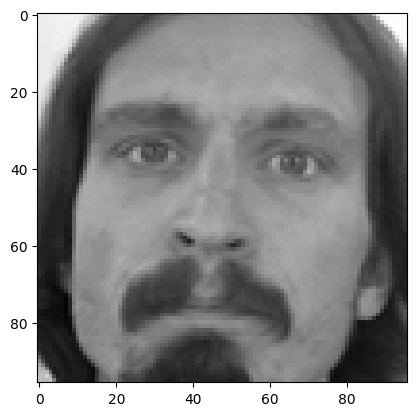

In [10]:
plt.imshow(X_train[0].reshape(96,96),cmap='gray')
plt.show()

Now we separate labels and we normalize the pixel values. 

In [11]:
y_train = train_data.drop(columns=['Image']).values.astype('float32')
y_train /= 96.0


As the data is ready for training , lets define the model. I am using keras and simple dense layers. For loss function I am using 'mse' ( mean squared error ) as we have to predict new values. Our result evaluted on the basics of 'mae' ( mean absolute error ).

In [12]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (
    Activation, Convolution2D, MaxPooling2D, BatchNormalization,
      Flatten, Dense, Dropout, Conv2D,MaxPool2D, ZeroPadding2D
)
from tensorflow.keras.layers import LeakyReLU


Dense() is a fully connected neural network layer. It takes all the input values, applies the weights and adds a bias, then it is passed through an activation function.
Dense() only accepts 1D input per sample. Hence we flatten the samples before they go through dense().
Conv2D is a filter that will slide across all the image to detect patterns like the nose, edges, corners etc... (as seen in the course INFO-H-500)
LeakyReLu() is an activation function. For ReLu(), if the input is positive it passes it through, else it sets it to 0. However some neurons can "die" if the input they recieve is always negative. With LeakyReLu(), if it is negative it is shrinked to 10% of its original value, allowing some negative values to pass and preserving the neurons.

In [13]:
model = Sequential()

model.add(Convolution2D(32, (3,3), padding='same', use_bias=False, input_shape=(96,96,1)))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())

model.add(Convolution2D(32, (3,3), padding='same', use_bias=False))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Convolution2D(64, (3,3), padding='same', use_bias=False))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())

model.add(Convolution2D(64, (3,3), padding='same', use_bias=False))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Convolution2D(96, (3,3), padding='same', use_bias=False))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())

model.add(Convolution2D(96, (3,3), padding='same', use_bias=False))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Convolution2D(128, (3,3),padding='same', use_bias=False))
# model.add(BatchNormalization())
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())

model.add(Convolution2D(128, (3,3),padding='same', use_bias=False))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Convolution2D(256, (3,3),padding='same',use_bias=False))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())

model.add(Convolution2D(256, (3,3),padding='same',use_bias=False))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Convolution2D(512, (3,3), padding='same', use_bias=False))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())

model.add(Convolution2D(512, (3,3), padding='same', use_bias=False))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())


model.add(Flatten())
model.add(Dense(512,activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(30))
model.summary()

c:\Users\Zeid le suceur\PycharmProjects\nour\venv\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\Zeid le suceur\PycharmProjects\nour\venv\lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 96, 96, 32)     │           288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 96, 96, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 96, 96, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 96, 96, 32)     │         9,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 96, 96, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 96, 96, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 48, 48, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 48, 48, 64)     │        18,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 48, 48, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 48, 48, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 48, 48, 64)     │        36,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 48, 48, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 48, 48, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 24, 24, 96)     │        55,296 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 24, 24, 96)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 24, 24, 96)     │           384 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 24, 24, 96)     │        82,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_5 (LeakyReLU)       │ (None, 24, 24, 96)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 24, 24, 96)     │           384 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 12, 12, 96)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 12, 12, 128)    │       110,59

 Total params: 7,268,670 (27.73 MB)

 Trainable params: 7,264,318 (27.71 MB)

 Non-trainable params: 4,352 (17.00 KB)

Now we have to tell Keras how to train the model. We use mean squared error (MSE) to calculate the error in our regression based model. The metrics chosen is the mean absolute error (MAE) because it is easier to read and interpret than the MSE. Adam adapts weights based on past updates. I also used data augmentation to train a more robust model. 

In [14]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create a generator with random transformations
datagen = ImageDataGenerator(
    rotation_range=15,       # rotate images randomly by ±15 degrees
    width_shift_range=0.1,   # shift images horizontally by ±10%
    height_shift_range=0.1,  # shift images vertically by ±10%
    zoom_range=0.1,          # zoom images by ±10%
    shear_range=0.1,         # shear intensity
    brightness_range=[0.8,1.2],  # vary brightness
    horizontal_flip=True,    # flip images horizontally (useful for faces)
    fill_mode='nearest'      # fill in newly created pixels after shifting
)

model.compile(optimizer='adam', 
              loss='mean_squared_error',
              metrics=['mae'])

Our model is now defined and we will train it by calling fit method. I ran it for 50 epochs keeping batch size and validtion set size as 20% ( 20% of the training data will be kept for validating the model ). 20% of the whole testing samples will be set aside and never be used for training, only to validate the model. Epochs is the number of full passes of the entire dataset. Every batch has 256 samples. 

In [15]:
from sklearn.model_selection import train_test_split


In [16]:
# Manual split
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
batch_size = 256

# Train model — remove steps_per_epoch
model.fit(
    datagen.flow(X_train, y_train, batch_size=batch_size),
    epochs=50,
    validation_data=(X_val, y_val)
)


c:\Users\Zeid le suceur\PycharmProjects\nour\venv\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 207s 8s/step - loss: 2.4572 - mae: 0.9692 - val_loss: 0.1909 - val_mae: 0.3943
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 160s 7s/step - loss: 0.0478 - mae: 0.1698 - val_loss: 0.1317 - val_mae: 0.3344
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 151s 7s/step - loss: 0.0206 - mae: 0.1082 - val_loss: 0.0879 - val_mae: 0.2741
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 160s 7s/step - loss: 0.0157 - mae: 0.0946 - val_loss: 0.0587 - val_mae: 0.2185
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 145s 6s/step - loss: 0.0132 - mae: 0.0867 - val_loss: 0.0471 - val_mae: 0.1929
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 149s 6s/step - loss: 0.0140 - mae: 0.0895 - val_loss: 0.0287 - val_mae: 0.1463
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 143s 6s/step - loss: 0.0121 - mae: 0.0833 - val_loss: 0.0226 - val_mae: 0.1228
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 144s 6s/step - loss: 0.0116 - mae: 0.0817 - val_loss: 0.0138 - val_mae: 0.0957
Epoch 9/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 141s 6s/step - loss: 0.016

Now lets prepare our testing data

In [17]:
#preparing test data
timag = []
for i in range(0,len(test_data)):
    timg = test_data['Image'][i].split(' ')
    timg = ['0' if x == '' else x for x in timg]
    timag.append(timg)

We reshape and convert to float

In [18]:
timage_list = np.array(timag,dtype = 'float')
X_test = timage_list.reshape(-1,96,96,1)
X_test /= 96.0

Lets see the first image in out test dataset and try to predict the result

56/56 ━━━━━━━━━━━━━━━━━━━━ 10s 168ms/step


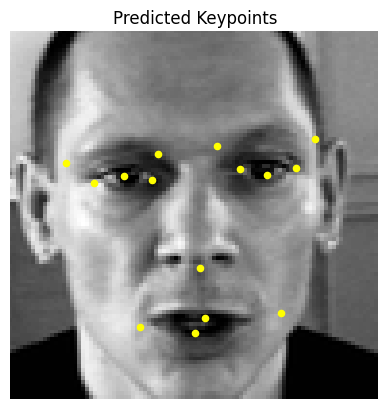

In [19]:
# Predict
pred = model.predict(X_test)
pred *= 96.0

# Plot image
fig, ax = plt.subplots()
ax.imshow((X_test[2] * 96.0).reshape(96,96), cmap='gray')

# Plot keypoints
ax.scatter(pred[2][0::2], pred[2][1::2], color='yellow', s=20)

# Set axis limits so the image and dots align
ax.set_xlim(0, 96)
ax.set_ylim(96, 0)  # Invert Y axis because images have (0,0) at top-left

ax.set_title('Predicted Keypoints')
ax.axis('off')
plt.show()

Now the last step is to create a submission file. There should be two columns :- RowId and Location. Location column values should be filled according the lookup table provided ( IdLookupTable.csv)

In [20]:
# pred is your model predictions
# pred shape = (num_images, 30)

# Create a DataFrame directly from pred
submission = pd.DataFrame(pred)

# Add an ImageId if needed
submission['ImageId'] = range(len(submission))

# Move ImageId to first column
columns = ['ImageId'] + list(range(30))
submission = submission[columns]

# Save to CSV
submission.to_csv('face_key_detection_submission.csv', index=False)


Now I will test this model on another database to see how it fares. For that purpose, i have the true keypoint values on an xml file. I will first parse them.

In [74]:
import xml.etree.ElementTree as ET

# Define the order your model expects
keypoint_names = [
    "left_eye_center",
    "right_eye_center",
    "left_eye_inner_corner",
    "left_eye_outer_corner",
    "right_eye_inner_corner",
    "right_eye_outer_corner",
    "left_eyebrow_inner_end",
    "left_eyebrow_outer_end",
    "right_eyebrow_inner_end",
    "right_eyebrow_outer_end",
    "nose_tip",
    "mouth_left_corner",
    "mouth_right_corner",
    "mouth_center_top_lip",
    "mouth_center_bottom_lip"
]

# This maps each keypoint_name to its index in the XML order
xml_index_by_label = {
    "right_eyebrow_inner_end": 0,
    "left_eyebrow_outer_end": 1,
    "left_eyebrow_inner_end": 2,
    "right_eye_outer_corner": 3,
    "right_eye_center": 4,
    "left_eye_inner_corner": 5,
    "right_eye_inner_corner": 6,
    "mouth_center_top_lip": 7,
    "left_eye_outer_corner": 8,
    "left_eye_center": 9,
    "mouth_center_bottom_lip": 10,
    "mouth_right_corner": 11,
    "mouth_left_corner": 12,
    "nose_tip": 13,
    "right_eyebrow_outer_end": 14
}

# Parse the XML
xml_path = 'data/raw/annotations.xml'
tree = ET.parse(xml_path)
root = tree.getroot()

# Store results
true_keypoints_real = {}

for image_tag in root.findall('image'):
    img_name = image_tag.attrib['name'].split('/')[-1]
    point_tags = image_tag.findall('points')

    if len(point_tags) != 15:
        continue  # Skip if not enough keypoints

    # Extract all (x, y) values into a flat list in XML order
    coords = []
    for pt in point_tags:
        x, y = map(float, pt.attrib['points'].split(','))
        coords.extend([x, y])

    # Reorder to match the model's training format
    ordered_points = []
    for label in keypoint_names:
        i = xml_index_by_label[label]
        x = coords[2 * i]
        y = coords[2 * i + 1]
        ordered_points.extend([x, y])

    true_keypoints_real[img_name] = ordered_points

print(true_keypoints_real['2.jpg'])


[2945.19, 1363.44, 2822.68, 1253.11, 2274.36, 1388.58, 3072.6, 1378.17, 2380.1, 1364.31, 3212.82, 1252.66, 2665.42, 1639.51, 2901.3, 2002.99, 2408.57, 2002.99, 2122.5, 1284.6, 2514.2, 1239.5, 2651.94, 2109.78, 2657.18, 1914.63, 2507.5, 1406.78, 2809.81, 1408.34]


Now let's predict the keypoints pixel positions with our model. But before, our model was trained on pictures already centered on the face. The new dataset doesn't respect this constraint. Therefore, I will crop the pictures based on the min/max pixel x, y coordinates to estimate a good facial crop.

In [22]:
#!pip install opencv-python

In [38]:
import cv2

In [39]:
def crop_face_from_keypoints(img, keypoints, margin=200):
    """
    img: the original large image (grayscale)
    keypoints: a list of 30 real pixel coordinates [x1, y1, x2, y2, ..., x15, y15]
    margin: extra pixels to add around the bounding box
    """

    x_points = keypoints[0::2]  # Take all x
    y_points = keypoints[1::2]  # Take all y

    min_x = int(max(min(x_points) - margin, 0))
    max_x = int(min(max(x_points) + margin, img.shape[1]))

    min_y = int(max(min(y_points) - margin, 0))
    max_y = int(min(max(y_points) + margin, img.shape[0]))

    # Crop the image
    face_crop = img[min_y:max_y, min_x:max_x]

    return face_crop


In [58]:
# Path to your image folder
image_folder = 'data/raw/FacialKeypointDetection/FKP/'

predictions = {}

for img_name in sorted(true_keypoints_real.keys()):  # true_keypoints_real has real (not scaled) points
    img_path = os.path.join(image_folder, img_name)

    # Load the original image in grayscale
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        print(f"Image {img_name} not found!")
        continue

    # Crop the face using true keypoints
    keypoints = true_keypoints_real[img_name]
    face_crop = crop_face_from_keypoints(img, keypoints, margin=20)

    # Resize cropped face to 96x96
    face_resized = cv2.resize(face_crop, (96, 96))

    # Prepare input for model
    img_input = face_resized.astype('float32') / 96.0
    img_input = img_input.reshape(1, 96, 96, 1)

    # Predict keypoints
    pred = model.predict(img_input)[0] * 96.0  # Flatten and rescale prediction

    # Save prediction
    predictions[img_name] = pred


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


In [63]:
def plot_predicted_keypoints(img_path, keypoints, model, margin=200):
    """
    img_path: path to the original image
    keypoints: list of 30 real keypoints (not scaled)
    model: your trained keypoint detection model
    margin: extra space around the bounding box
    """

    # Load the original grayscale image
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        print(f"Error: Could not load image {img_path}")
        return

    # Crop the face from the original image
    face_crop = crop_face_from_keypoints(img, keypoints, margin=margin)

    # Resize cropped face to 96x96
    face_resized = cv2.resize(face_crop, (96, 96))

    # Prepare input for model
    img_input = face_resized.astype('float32') / 96.0
    img_input = img_input.reshape(1, 96, 96, 1)

    # Predict keypoints
    pred = model.predict(img_input)[0] * 96.0  # Rescale prediction

    # ---- Prepare true keypoints relative to cropped face ----
    x_points = keypoints[0::2]
    y_points = keypoints[1::2]

    min_x = int(max(min(x_points) - margin, 0))
    max_x = int(min(max(x_points) + margin, img.shape[1]))
    min_y = int(max(min(y_points) - margin, 0))
    max_y = int(min(max(y_points) + margin, img.shape[0]))

    true_pts_cropped = []

    for i in range(15):
        x = keypoints[2 * i]
        y = keypoints[2 * i + 1]
        x_cropped = (x - min_x) * (96 / (max_x - min_x))
        y_cropped = (y - min_y) * (96 / (max_y - min_y))
        true_pts_cropped.extend([x_cropped, y_cropped])

    true_pts_cropped = np.array(true_pts_cropped)

    # ---- Plot predicted and true keypoints with labels ----
    fig, ax = plt.subplots()
    ax.imshow(face_resized, cmap='gray')

    # Plot predicted keypoints in yellow with numbers
    for i in range(15):
        x_pred = pred[2 * i]
        y_pred = pred[2 * i + 1]
        ax.scatter(x_pred, y_pred, color='yellow', s=20)
        ax.text(x_pred + 1, y_pred - 1, str(i), color='yellow', fontsize=8)

    # Plot true keypoints in blue with numbers
    for i in range(15):
        x_true = true_pts_cropped[2 * i]
        y_true = true_pts_cropped[2 * i + 1]
        ax.scatter(x_true, y_true, color='blue', s=20)
        ax.text(x_true + 1, y_true - 1, str(i), color='blue', fontsize=8)

    ax.set_xlim(0, 96)
    ax.set_ylim(96, 0)
    ax.axis('off')
    plt.title('Keypoints: Predicted (yellow) vs True (blue)')
    plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


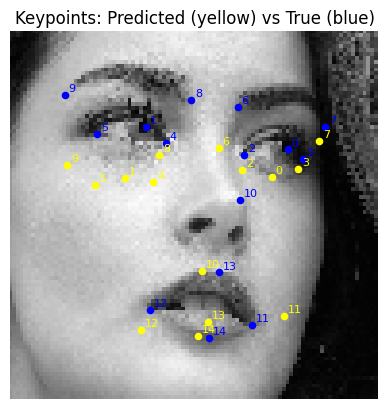

In [73]:
img_name = '1.jpg'
img_path = os.path.join(image_folder, img_name)

plot_predicted_keypoints(img_path, true_keypoints_real[img_name], model, margin=200)


In [ ]:
for img_name, pred in predictions.items():
    print(f"Image: {img_name}")
    print(pred)
    print("-" * 50)
    

Image: 1.jpg
[68.5452   38.254883 30.289364 38.39724  60.68383  36.484333 75.24072
 36.148643 37.54366  39.317215 22.20161  40.065685 54.702427 30.47295
 81.08493  28.700794 38.987762 32.330776 15.034049 34.785114 50.233124
 62.87195  71.73039  74.443794 34.249268 78.27465  51.612797 76.05919
 49.186787 79.68492 ]
--------------------------------------------------
Image: 10.jpg
[69.33283   38.567856  30.617     38.84531   61.401947  36.754585
 76.45668   36.45158   37.999924  39.678577  22.435452  40.42337
 55.149593  30.787748  81.72441   28.96304   39.557816  32.65592
 15.1340885 35.11699   50.849716  63.42317   72.79599   75.43657
 34.66074   79.2055    52.34939   76.87557   49.672966  80.564865 ]
--------------------------------------------------
Image: 11.jpg
[68.08909  37.987526 29.878023 38.31434  61.081078 35.952057 75.26012
 36.09533  37.451015 39.162514 22.416126 40.105804 54.517014 30.556211
 80.27902  28.401094 38.76641  32.244804 14.949706 34.755787 50.797096
 62.504433 71

Now let's compare the predictions to the true values.

In [67]:
errors = []

for img_name, real_keypoints in true_keypoints_real.items():
    img_path = os.path.join(image_folder, img_name)

    # Load grayscale image
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        print(f"Error: Could not load {img_name}")
        continue

    # Crop the face using keypoints
    face_crop = crop_face_from_keypoints(img, real_keypoints, margin=20)

    # Resize to model input shape
    face_resized = cv2.resize(face_crop, (96, 96))

    # Prepare image for prediction
    img_input = face_resized.astype('float32') / 96.0
    img_input = img_input.reshape(1, 96, 96, 1)

    # Predict and rescale keypoints
    pred_pts = model.predict(img_input)[0] * 96.0
    # Align true keypoints to cropped image
    x_points = real_keypoints[0::2]
    y_points = real_keypoints[1::2]

    min_x = int(max(min(x_points) - 20, 0))
    max_x = int(min(max(x_points) + 20, img.shape[1]))
    min_y = int(max(min(y_points) - 20, 0))
    max_y = int(min(max(y_points) + 20, img.shape[0]))

    true_pts_cropped = []
    for i in range(15):
        x = real_keypoints[2 * i]
        y = real_keypoints[2 * i + 1]
        x_cropped = (x - min_x) * (96 / (max_x - min_x))
        y_cropped = (y - min_y) * (96 / (max_y - min_y))
        true_pts_cropped.extend([x_cropped, y_cropped])

    true_pts_cropped = np.array(true_pts_cropped)
    # Compute MSE for this image
    mse = np.mean((true_pts_cropped - pred_pts) ** 2)
    errors.append(mse)

# Compute average MSE
avg_mse = np.mean(errors)
print(f"Average MSE across test images: {avg_mse:.2f}")
print(errors)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
Average MSE across test images: 1114.63
[216.01723118073934, 1227.5230344655845, 1118.8564787441426, 1692.8517596883235, 651.4497830269343, 1591.1738994137736, 886.8646382916087, 1258.7058117353488, 1048.5255119785668, 1083.9230127092737, 1534.4380764578316, 952.8870515490628, 1367.601111675079, 851.7342329750652, 1236.9189114169053]


The list of MSEs shows that the same keypoint coordinates have a different order for every image in the external dataset.